In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import warnings
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [25]:
transform = Compose([Resize((64, 64)), ToTensor()])
data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)

train_dataloader = DataLoader(data_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=128, shuffle=True)

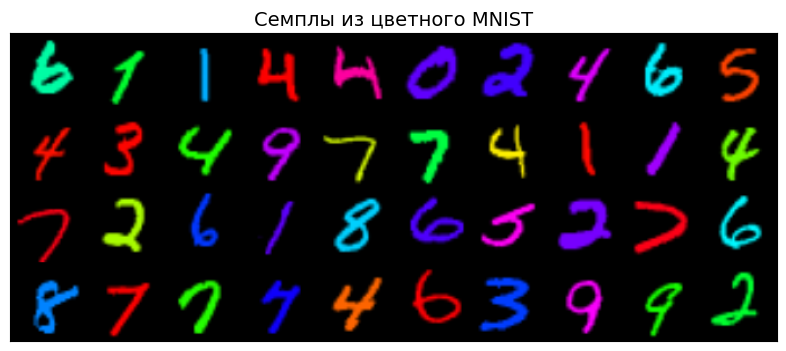

In [5]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

batch = next(iter(train_dataloader))
visualize_batch(batch[0][:40])

In [6]:
!git clone https://github.com/alexzhou907/DDBM

fatal: destination path 'DDBM' already exists and is not an empty directory.


In [7]:
import sys
sys.path.append('/kaggle/working/DDBM')
sys.path.append('/kaggle/working/DDBM/ddbm')
sys.path.append('/kaggle/input/diffusion-project-weights')

!pip install piq
!pip install einops
!pip install flash_attn

In [49]:
import pickle
from ddbm.script_util import create_model

# внести в файл cunet.py
class EDMPrecond(nn.Module):
    def __init__(self, model, sigma_data=0.5):
        super().__init__()
        self.sigma_data = sigma_data
        self.model = model

    def forward(self, x, sigma, cond):
        sigma = sigma.reshape(-1, 1, 1, 1)

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        with torch.autocast(device_type="cuda"):
            F_x = self.model(
                (c_in * x).to(torch.float32), 
                c_noise.flatten().to(torch.float32), 
                cond.to(torch.float32)
            )
        D_x = c_skip * x + c_out * F_x
        return D_x

cunet = create_model(image_size=64,
                     in_channels=3,
                     num_channels=128,
                     num_res_blocks=2,
                     unet_type='adm',
                     attention_type='',
                     condition_mode='concat',
                     #use_fp16=True,
                     resblock_updown=True)
cunet = EDMPrecond(cunet)
cunet_ddp = torch.nn.DataParallel(cunet, device_ids=[0, 1])

/tmp/ipykernel_27998/1946977824.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/kaggle/input/diffusion-project-weights/i2sb_weight_inv_mnist.pt')


In [50]:
import torchvision

#x1 -- corrupt, x0 -- real
def blur(x):
    return transforms.functional.gaussian_blur(x, 11, 4)

def inprinting(x):
    return transforms.functional.erase(x, 0, x.shape[3] // 2, x.shape[2], x.shape[3] // 2, 1.)

def inverse(x):
    mask = (x == 0)
    return mask * x + (~mask) * (1.-x)
    # return -x

class I2SB():
    def __init__(self, cunet, betas, device='cuda', corruption_fn=blur, stochastic=True, add_noise_to_x1=False):
        self.cunet = cunet.to(device)
        self.corruption = corruption_fn
        self.num_steps = len(betas)
        self.device = device

        self.betas = betas.to(device)
        self.sigmas2 = torch.cumsum(betas, dim=0).to(device)
        self.sigmas = torch.sqrt(self.sigmas2).to(device)
        self.over_sigmas2 = betas.sum() - torch.cat((torch.tensor([0], device=device), self.sigmas2[:-1]), dim=0).to(device)
        
        self.mus_t0 = self.over_sigmas2 / (self.sigmas2 + self.over_sigmas2).to(device)
        self.mus_t1 = self.sigmas2 / (self.sigmas2 + self.over_sigmas2).to(device)
        self.var = (self.sigmas2 * self.over_sigmas2) / (self.sigmas2 + self.over_sigmas2).to(device)
        
        self.stochastic = stochastic
        self.add_noise_to_x1 = add_noise_to_x1

    def get_pred_x0(self, xt, step, cond):
        pred = self.cunet(xt, self.sigmas[step], cond)
        return pred

    def get_xt(self, x0, x1, steps):
        xt = self.mus_t0[steps].view(-1, 1, 1, 1) * x0 + self.mus_t1[steps].view(-1, 1, 1, 1) * x1
        if self.stochastic:
            xt = xt + torch.sqrt(self.var[steps]).view(-1, 1, 1, 1) * torch.randn_like(xt)
        return xt

    def get_xt_from_sigmas(self, x0, x1, sigma2, over_sigma2):
        mus_t0 = over_sigma2 / (sigma2 + over_sigma2)
        mus_t1 = sigma2 / (sigma2 + over_sigma2)
        
        xt = mus_t0 * x0 + mus_t1 * x1
        
        if self.stochastic:
            var = (over_sigma2 * sigma2) / (sigma2 + over_sigma2)
            xt += torch.sqrt(var) * torch.randn_like(xt)

        return xt

    def get_next_xt(self, xt_now, x0, step_now, step_next):
        sigma2 = self.sigmas2[step_next]
        over_sigma2 = self.sigmas2[step_now] - self.sigmas2[step_next]

        return self.get_xt_from_sigmas(x0, xt_now, sigma2, over_sigma2)

    def sampling(self, x1, steps):
        xt_now = x1
        trajectory = [x1]
        
        with torch.no_grad():
            for i in range(len(steps) - 1, 0, -1):
                step = steps[i] * torch.ones((xt_now.shape[0], ), dtype=int, device=self.device)
                
                x0 = self.get_pred_x0(xt_now, step, x1)
                xt_now = self.get_next_xt(xt_now, x0, steps[i], steps[i - 1])
                trajectory.append(xt_now)

        return xt_now, trajectory

    def loss(self, x0, x1):
        steps = torch.randint(low=0, high=self.num_steps, size=(x0.shape[0],), device=x1.device)
        xt = self.get_xt(x0, x1, steps)
        x0_pred = self.get_pred_x0(xt, steps, x1)

        return torch.mean(torch.square(x0_pred - x0))

    def visualize_training(self, x0, x1, loss_history):
        self.cunet.eval()
        clear_output(wait=True)
        
        visualize_batch(x1[0:10].cpu(), title='corrupt')
        visualize_batch(self.sampling(x1[0:10], np.arange(0, self.num_steps, 1))[0].cpu(), title='predictions')
        visualize_batch(x0[0:10].cpu(), title='original')
    
        #visualize_training(model, loss_history, log_imgs, sampling_params, cond=y)
        plt.plot(np.arange(len(loss_history)), loss_history)
        plt.yscale('log')
        # plt.ylim(0, 5)
        plt.grid(True)
        plt.title('Лосс на обучении', fontsize=17)
        plt.xlabel('Итерация', fontsize=14)
        plt.tick_params(labelsize=13)
        plt.plot(loss_history)
        plt.show()

    def train(self, opt, train_dataloader, n_epochs, eval_every=100, loss_before=None, minibatch=1):
        loss_history = [] if loss_before is None else loss_before
        iter = 0
        with tqdm(total=len(train_dataloader) * n_epochs) as pbar:
            for epoch in range(n_epochs):
                for batch in train_dataloader:
                    self.cunet.train()
                    if iter % minibatch == 0:
                        opt.zero_grad()
                    x0 = batch[0].to(self.device)
                    x1 = self.corruption(x0) #(batch['A'] * 2 - 1).to(self.device)
                    
                    if self.add_noise_to_x1:
                        x1 += torch.randn_like(x1)
                    
                    loss = self.loss(x0, x1)
                    loss_history.append(loss.item())

                    if iter % minibatch == 0:
                        loss.backward()
                        opt.step()
    
                    if eval_every > 0 and iter % eval_every == 0:
                        self.visualize_training(x0, x1, loss_history)
    
                    pbar.update(1)
                    pbar.set_description('Loss: %.4g' % loss.item())
                    iter += 1

                if (epoch + 1) % 5 == 0:
                    checkpoint = { 
                        'epoch': epoch,
                        'model': model.cunet.state_dict(),
                        'optimizer': opt.state_dict(), 
                        'loss_history': loss_history}
                    torch.save(checkpoint, f'checkpoint_inv_mnist_{epoch}_epoch.pth')

        self.visualize_training(x0, x1, loss_history)

        return loss_history

In [56]:
n_timesteps=100
linear_start=1e-4
linear_end=2e-2
betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timesteps, dtype=np.float64) ** 2
betas = torch.tensor(np.concatenate([betas[:n_timesteps//2], np.flip(betas[:n_timesteps//2])]))

model=I2SB(cunet_ddp, betas, device='cuda', corruption_fn=inverse, stochastic=False)

params = [p for p in model.cunet.parameters() if p.requires_grad]
opt = torch.optim.AdamW(params, lr=1e-5)
loss_history = model.train(opt, train_dataloader, 50, eval_every=500, loss_before=[], minibatch=1)